In [1]:
# from math import pi

# import lenstronomy.Util.param_util as param_util
import torch
from astropy.cosmology import FlatLambdaCDM as FlatLambdaCDM_AP
from astropy.cosmology import default_cosmology

# next three imports to get Rs_angle and alpha_Rs in arcsec for lenstronomy
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
# from ..test.utils import lens_test_helper

from caustic.cosmology import FlatLambdaCDM as CausticFlatLambdaCDM
from caustic.lenses import NFW, TNFW

h0_default = float(default_cosmology.get().h)
Om0_default = float(default_cosmology.get().Om0)
Ob0_default = float(default_cosmology.get().Ob0)


/home/charles/miniconda3/envs/caustic/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
import numpy as np
import os
from glob import glob
import pandas as pd
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid

def display(arr, ax=None, lim=1, mid=0, title=None, fs=12, norm="Centered", cmap="bwr", cbar=True, axis=False):
	show = False
	if ax is None:
		fig, ax = plt.subplots(figsize=(6,6))
		show = True

	norm_kw = {}
	if norm == "Centered":
		norm_kw.update({"norm": colors.CenteredNorm(vcenter=mid)})
	elif norm == "Log":
		norm_kw.update({"norm": colors.LogNorm()})

	
	im = ax.imshow(arr, origin='lower', extent=(-lim, lim, -lim, lim),
				   cmap=cmap, **norm_kw)

	if cbar:
		div = make_axes_locatable(ax)
		cax = div.append_axes("right", size="5%", pad=0.1)
		plt.colorbar(im, cax=cax)

	tx = None
	if title is not None:
		tx = ax.set_title(title, fontsize=fs)

	if not axis:
		ax.axis("off")
		
	if show:
		plt.show()
		plt.close()

	return im, tx

In [3]:
from typing import Any, Dict, List, Union

from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel

from caustic.lenses import ThinLens
from caustic.lenses.base import ThickLens
from caustic.utils import get_meshgrid


def setup_grids(res=0.05, n_pix=100):
    # Caustic setup
    thx, thy = get_meshgrid(res, n_pix, n_pix)

    # Lenstronomy setup
    fov = res * n_pix
    ra_at_xy_0, dec_at_xy_0 = ((-fov + res) / 2, (-fov + res) / 2)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
    kwargs_pixel = {
        "nx": n_pix,
        "ny": n_pix,  # number of pixels per axis
        "ra_at_xy_0": ra_at_xy_0,
        "dec_at_xy_0": dec_at_xy_0,
        "transform_pix2angle": transform_pix2angle,
    }
    pixel_grid = PixelGrid(**kwargs_pixel)
    thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)
    return thx, thy, thx_ls, thy_ls


def alpha_test_helper(lens, lens_ls, z_s, x, kwargs_ls, atol, rtol):
    thx, thy, thx_ls, thy_ls = setup_grids()
    alpha_x, alpha_y = lens.reduced_deflection_angle(thx, thy, z_s, lens.pack(x))
    alpha_x_ls, alpha_y_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)
    print(alpha_x.numpy()[:10,:10])
    print(alpha_x_ls[:10,:10])

    display(alpha_x)
    display(alpha_x_ls)
    display(alpha_x - alpha_x_ls)
    display((alpha_x / alpha_x_ls).log())
    display((alpha_x / alpha_x_ls) - (alpha_x / alpha_x_ls).max())
    
    assert np.allclose(alpha_x.numpy(), alpha_x_ls, rtol, atol)
    assert np.allclose(alpha_y.numpy(), alpha_y_ls, rtol, atol)


def Psi_test_helper(lens, lens_ls, z_s, x, kwargs_ls, atol, rtol):
    thx, thy, thx_ls, thy_ls = setup_grids()
    Psi = lens.potential(thx, thy, z_s, lens.pack(x))
    Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)
    # Potential is only defined up to a constant
    Psi -= Psi.min()
    Psi_ls -= Psi_ls.min()

    display(Psi, cmap="hot", norm=None)
    display(Psi_ls, cmap="hot", norm=None)
    display(Psi - Psi_ls)
    
    assert np.allclose(Psi.numpy(), Psi_ls, rtol, atol)


def kappa_test_helper(lens, lens_ls, z_s, x, kwargs_ls, atol, rtol):
    thx, thy, thx_ls, thy_ls = setup_grids()
    kappa = lens.convergence(thx, thy, z_s, lens.pack(x))
    kappa_ls = lens_ls.kappa(thx_ls, thy_ls, kwargs_ls)

    display(kappa, cmap="twilight_r", norm=None)
    display(kappa_ls, cmap="twilight_r", norm=None)
    display(kappa - kappa_ls)
    
    assert np.allclose(kappa.numpy(), kappa_ls, rtol, atol)


def lens_test_helper(
    lens: Union[ThinLens, ThickLens],
    lens_ls: LensModel,
    z_s,
    x,
    kwargs_ls: List[Dict[str, Any]],
    rtol,
    atol,
    test_alpha=True,
    test_Psi=True,
    test_kappa=True,
):
    if test_alpha:
        alpha_test_helper(lens, lens_ls, z_s, lens.pack(x), kwargs_ls, atol, rtol)

    if test_Psi:
        Psi_test_helper(lens, lens_ls, z_s, lens.pack(x), kwargs_ls, atol, rtol)

    if test_kappa:
        kappa_test_helper(lens, lens_ls, z_s, lens.pack(x), kwargs_ls, atol, rtol)


In [4]:
thx, thy, thx_ls, thy_ls = setup_grids()

## NFW test

NFW(
    name='nfw',
    static=[z_l],
    dynamic=[x0, y0, m, c],
    x keys=[('nfw': ['x0', 'y0', 'm', 'c'])]
)
[[-0.1990057  -0.1961852  -0.19333634 -0.19049297 -0.18763159 -0.18474017
  -0.1818295  -0.17888759 -0.17594841 -0.17296524]
 [-0.19953476 -0.19671367 -0.19388731 -0.19103168 -0.1881697  -0.18526547
  -0.18235368 -0.17941016 -0.17646962 -0.17348444]
 [-0.20005068 -0.19722913 -0.19440237 -0.19155802 -0.18868348 -0.18580209
  -0.18287721 -0.17994423 -0.17699055 -0.1740275 ]
 [-0.20056438 -0.19775447 -0.19492745 -0.1920706  -0.18921974 -0.1863256
  -0.18341179 -0.18047772 -0.17752278 -0.1745585 ]
 [-0.20107521 -0.19827743 -0.19546258 -0.19259293 -0.18972956 -0.1868471
  -0.18394496 -0.18100996 -0.17806636 -0.17508848]
 [-0.2016074  -0.19880982 -0.19597006 -0.19312495 -0.19026133 -0.18737857
  -0.18447599 -0.18154019 -0.17859584 -0.17562954]
 [-0.20212346 -0.19931343 -0.19648606 -0.19365369 -0.19079    -0.18789415
  -0.18499124 -0.18206765 -0.17912272 -0.17614263]
 [-0.20263487

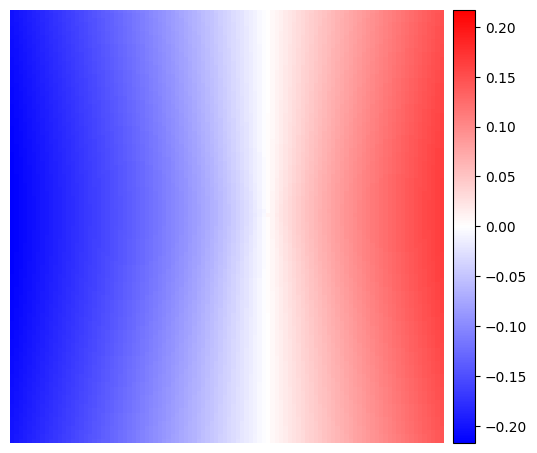

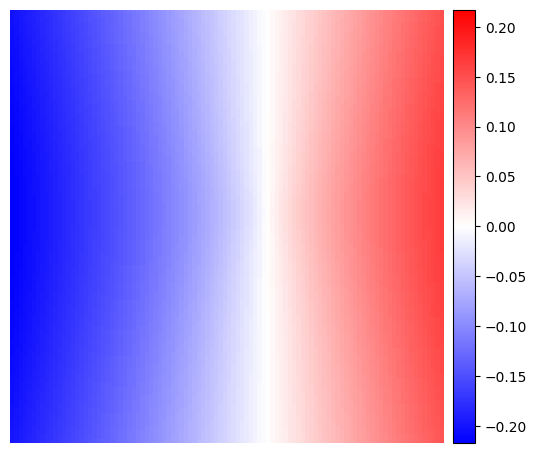

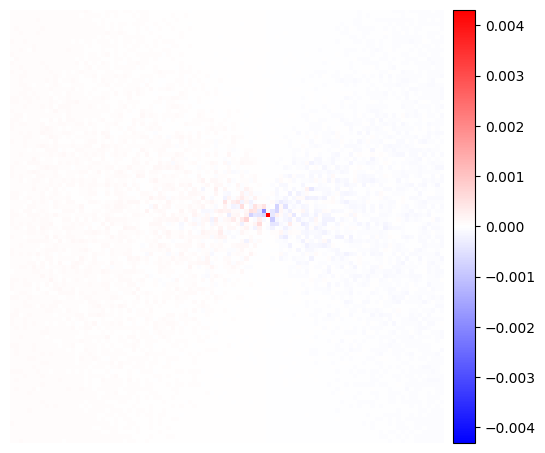

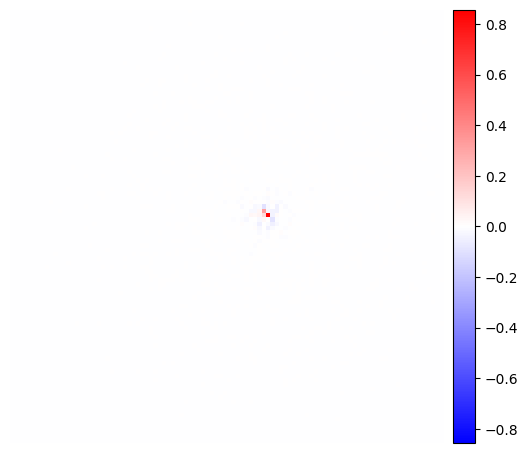

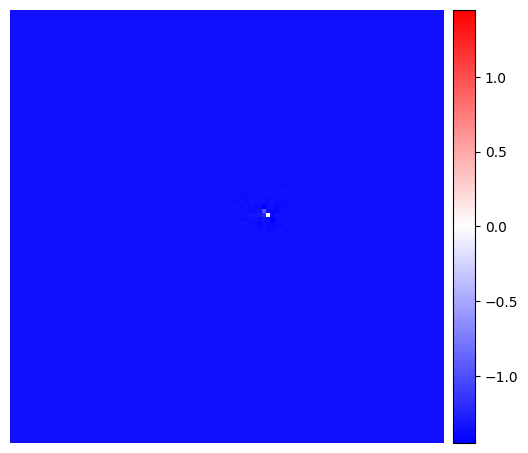

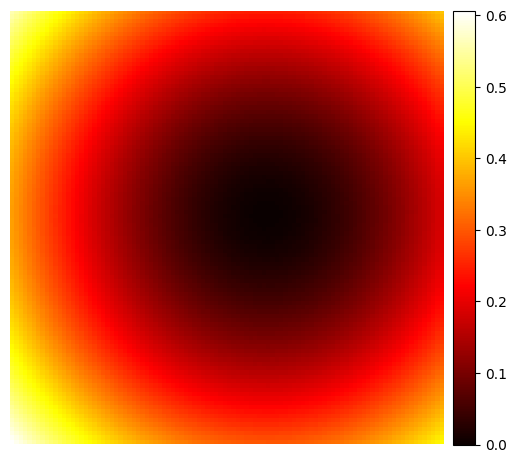

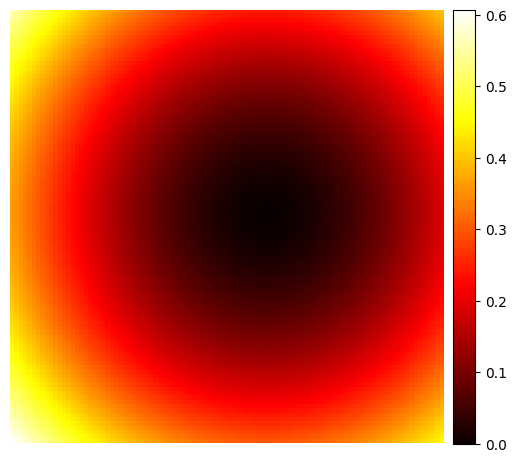

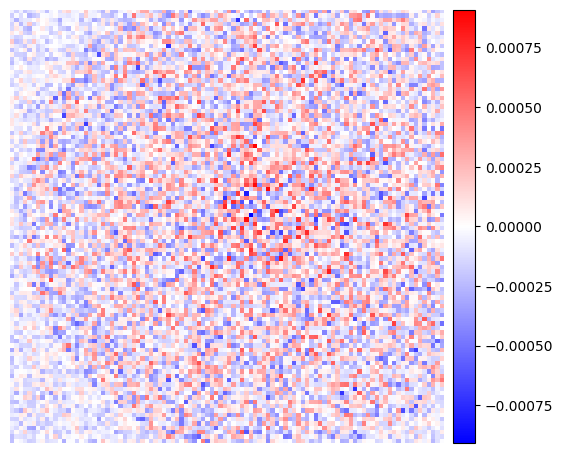

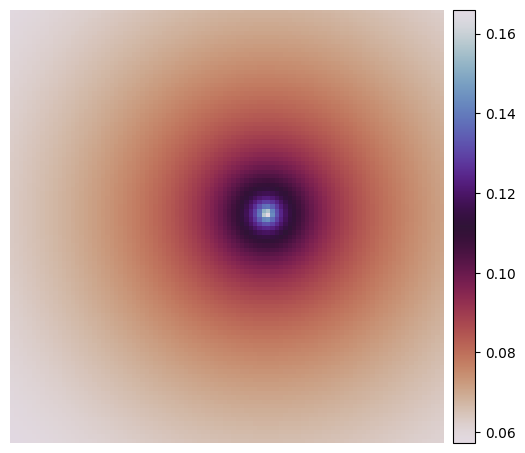

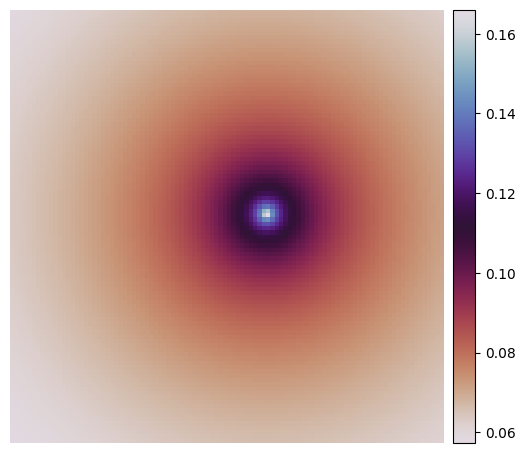

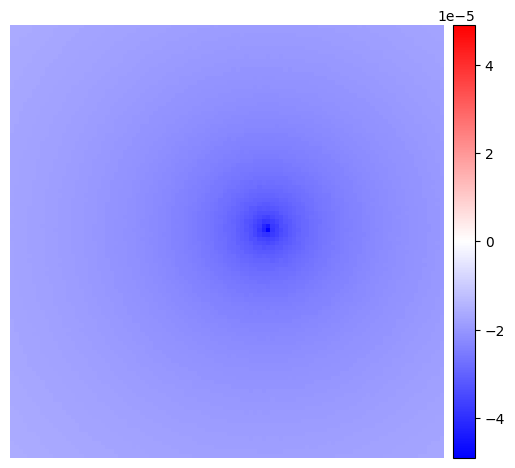

In [99]:
atol = 1e-5
rtol = 3e-2



# Models
cosmology = CausticFlatLambdaCDM("cosmo")
z_l = torch.tensor(0.1)
lens_nfw = NFW("nfw", cosmology, z_l=z_l)
lens_model_list = ["NFW"]
lens_ls = LensModel(lens_model_list=lens_model_list)

print(lens_nfw)

# Parameters
z_s = torch.tensor(0.5)

x0 = 0.457
y0 = 0.141
m = 1e13
c = 3.0
params_nfw = lens_nfw.pack(torch.tensor([x0, y0, m, c]))

# Lenstronomy
cosmo = FlatLambdaCDM_AP(H0=h0_default * 100, Om0=Om0_default, Ob0=Ob0_default)
lens_cosmo = LensCosmo(z_lens=z_l.item(), z_source=z_s.item(), cosmo=cosmo)
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=m, c=c)

# lenstronomy params ['Rs', 'alpha_Rs', 'center_x', 'center_y']
kwargs_ls = [
    {"Rs": Rs_angle, "alpha_Rs": alpha_Rs, "center_x": x0, "center_y": y0}
]

lens_test_helper(lens_nfw, lens_ls, z_s, params_nfw, kwargs_ls, atol, rtol)

In [ ]:
# z_l, x0, y0, m, c = lens_nfw.unpack(params_nfw)

ax_nfw, ay_nfw = lens_nfw.reduced_deflection_angle(thx, thy, z_s, params_nfw)
kappa_nfw = lens_nfw.convergence(thx ,thy, z_s, params_nfw)
potential_nfw = lens_nfw.potential(thx ,thy, z_s, params_nfw)

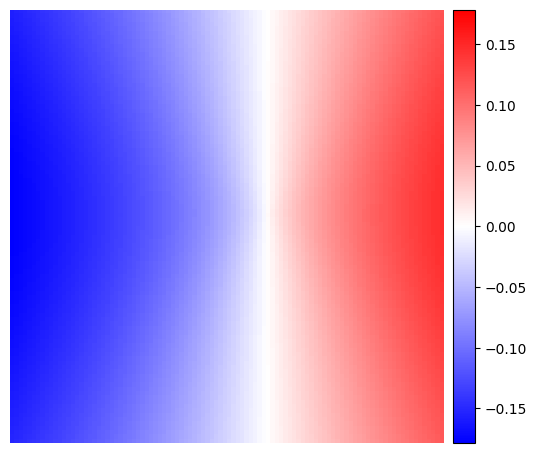

(<matplotlib.image.AxesImage at 0x7f092f805100>, None)

In [7]:
display(ax_nfw)
# display(kappa_nfw, cmap="hot", norm=None)

## TNFW test

In [115]:
from math import pi
from typing import Any, Optional

import torch
from torch import Tensor

from caustic.constants import G_over_c2, arcsec_to_rad, rad_to_arcsec
from caustic.cosmology import Cosmology
from caustic.utils import translate_rotate
from caustic.lenses.base import ThinLens

DELTA = 200.0

__all__ = ("TNFW",)


class TNFW(ThinLens):
    """
    Truncated NFW lens class. This class models a lens using the Truncated Navarro-Frenk-White (TNFW) profile,
    with a truncation function (r_trunc^2)/(r^2+r_trunc^2), as described in https://arxiv.org/abs/1101.0650
    for n=1. 
    
    Attributes:
        z_l (Optional[Tensor]): Redshift of the lens. Default is None.
        x0 (Optional[Tensor]): x-coordinate of the lens center in the lens plane. 
            Default is None.
        y0 (Optional[Tensor]): y-coordinate of the lens center in the lens plane. 
            Default is None.
        m (Optional[Tensor]): Mass of the lens in Msun. Default is None.
        c (Optional[Tensor]): Concentration parameter of the lens. Default is None.
        r_trunc (Optional[Tensor]): Truncation radius of the the lens in arcsecs. Default is None.
        s (float): Softening parameter to avoid singularities at the center of the lens. 
            Default is 0.0.
    Methods:
        get_scale_radius: Returns the scale radius of the lens.
        get_scale_density: Returns the scale density of the lens.
        get_convergence_s: Returns the dimensionless surface mass density of the lens.
        _f: Helper method for computing deflection angles.
        _g: Helper method for computing lensing potential.
        _h: Helper method for computing reduced deflection angles.
        deflection_angle_hat: Computes the reduced deflection angle.
        deflection_angle: Computes the deflection angle.
        convergence: Computes the convergence (dimensionless surface mass density).
        potential: Computes the lensing potential.
    """
    def __init__(
        self,
        name: str,
        cosmology: Cosmology,
        z_l: Optional[Tensor] = None,
        x0: Optional[Tensor] = None,
        y0: Optional[Tensor] = None,
        m: Optional[Tensor] = None,
        c: Optional[Tensor] = None,
        r_trunc: Optional[Tensor] = None,
        s: float = 0.001,   # arcsecs
    ):
        """
        Initialize an instance of the TNFW lens class.
        """
        super().__init__(name, cosmology, z_l)

        self.add_param("x0", x0)
        self.add_param("y0", y0)
        self.add_param("m", m)
        self.add_param("c", c)
        self.add_param("r_trunc", r_trunc)
        self.s = torch.tensor(s)

    def get_scale_radius(self, z_l: Tensor, m: Tensor, c: Tensor, params: Optional["Packed"] = None) -> Tensor:
        """
        Calculate the scale radius of the lens.

        Args:
            z_l (Tensor): Redshift of the lens.
            m (Tensor): Mass of the lens.
            c (Tensor): Concentration parameter of the lens.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: The scale radius of the lens in Mpc.
        """
        critical_density = self.cosmology.critical_density(z_l, params)
        r_delta = (3 * m / (4 * pi * DELTA * critical_density)) ** (1 / 3)
        return 1 / c * r_delta

    def get_scale_density(self, z_l: Tensor, c: Tensor, params: Optional["Packed"] = None) -> Tensor:
        """
        Calculate the scale density of the lens.

        Args:
            z_l (Tensor): Redshift of the lens.
            c (Tensor): Concentration parameter of the lens.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: The scale density of the lens in solar masses per Mpc cubed.
        """
        return (
            DELTA
            / 3
            * self.cosmology.critical_density(z_l, params)
            * c**3
            / (torch.log(1 + c) - c / (1 + c))
        )

    def get_convergence_s(self: Tensor, z_l: Tensor, z_s: Tensor, m: Tensor, c: Tensor, params: Optional["Packed"] = None) -> Tensor:
        """
        Calculate the dimensionless surface mass density of the lens at the scale radius.

        Args:
            z_l (Tensor): Redshift of the lens.
            z_s (Tensor): Redshift of the source.
            m (Tensor): Mass of the lens.
            c (Tensor): Concentration parameter of the lens.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: The dimensionless surface mass density of the lens.
        """
        critical_surface_density = self.cosmology.critical_surface_density(z_l, z_s, params)
        return self.get_scale_density(z_l, c, params) * self.get_scale_radius(z_l, m, c, params) / critical_surface_density

    def _F(self, r: Tensor) -> Tensor:
        """
        Helper function F for the TNFW profile.

        Args:
            r (Tensor): The scaled radius (xi / scale_radius)

        Returns:
            Tensor: Result of the F(X) function
        """
        # r = torch.maximum(r, self.s)
        return torch.where(
            r < 1,
            torch.where(
                r == 0,
                0.,
                ((1 - r ** 2).sqrt()).arctanh() / ((1 - r ** 2).sqrt())
            ),
            torch.where(
                r > 1,
                ((r ** 2 - 1).sqrt()).arctan() / ((r ** 2 - 1).sqrt()),
                1.0
                )
            )

    def _L(self, r: Tensor, tau: Tensor) -> Tensor:
        """
        Helper function L for the TNFW profile.

        Args:
            r (Tensor): The scaled radius (xi / scale_radius)
            z_l (Tensor): Redshift of the lens.
            m (Tensor): Mass of the lens.
            c (Tensor): Concentration parameter of the lens.
            r_trunc (Tensor): Truncation radius of the the lens.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: Result of the L(X) function
        """
        # scale_radius = self.get_scale_radius(z_l, m, c, params)
        # tau = r_trunc / scale_radius
        # r = torch.maximum(r, self.s)
        return (r / ((tau ** 2 + r ** 2).sqrt() + tau)).log()

    @staticmethod
    def _cos_function(r):
        """
        Function for extending domain of inverse cosine in 
        expression for the potential
        
        TODO: see where this comes from, Baltz 2009 only has cos^-1
        """
        return torch.where(
            r < 1,
            -torch.acosh(1 / r) ** 2,
            torch.where(
                r > 1,
                torch.acos(1 / r) ** 2,
                1.0
                )
            )
    
    def reduced_deflection_angle(self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None) -> tuple[Tensor, Tensor]:
        """
        Compute the reduced deflection angle.

        Args:
            x (Tensor): x-coordinates in the lens plane.
            y (Tensor): y-coordinates in the lens plane.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            tuple[Tensor, Tensor]: The reduced deflection angles in the x and y directions.
        """
        z_l, x0, y0, m, c, r_trunc = self.unpack(params)
        
        x, y = translate_rotate(x, y, x0, y0)
        th = (x ** 2 + y ** 2).sqrt()
        d_l = self.cosmology.angular_diameter_distance(z_l, params)

        # physical units
        scale_radius = self.get_scale_radius(z_l, m, c, params) 
        xi = d_l * th * arcsec_to_rad
        r_trunc_phys = d_l * r_trunc * arcsec_to_rad
        r = xi / scale_radius + self.s
        
        convergence_s = self.get_convergence_s(z_l, z_s, m, c, params)
        tau = r_trunc_phys / scale_radius
        
        F = self._F(r)
        L = self._L(r, tau)

        # TODO: compare first line between TNFW and TNFW_Baltz papers
        average_convergence = 4 * convergence_s * tau ** 2 / (r ** 2 * (tau ** 2  + 1) ** 2) * (
            (tau ** 2 + 1 + 2 * (r ** 2 - 1)) * F
            + tau * pi
            + (tau ** 2 - 1) * torch.log(tau)
            + (tau ** 2 + r ** 2).sqrt() * (- pi + (tau ** 2 - 1) / tau * L)
            )
        
        ax = average_convergence * x
        ay = average_convergence * y
        # d_s = self.cosmology.angular_diameter_distance(z_s, params)
        # d_ls = self.cosmology.angular_diameter_distance_z1z2(z_l, z_s, params)
        # return ax * d_ls / d_s, ay * d_ls / d_s
        return ax, ay

    def convergence(self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None) -> Tensor:
        """
        Compute the convergence (dimensionless surface density).

        Args:
            x (Tensor): x-coordinates in the lens plane.
            y (Tensor): y-coordinates in the lens plane.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.
        
        Returns:
            Tensor: The convergence
        """
        z_l, x0, y0, m, c, r_trunc = self.unpack(params)

        x, y = translate_rotate(x, y, x0, y0)
        th = (x ** 2 + y ** 2).sqrt() + self.s
        d_l = self.cosmology.angular_diameter_distance(z_l, params)
        scale_radius = self.get_scale_radius(z_l, m, c, params)
        xi = d_l * th * arcsec_to_rad
        r_trunc_phys = d_l * r_trunc * arcsec_to_rad
        r = xi / scale_radius

        convergence_s = self.get_convergence_s(z_l, z_s, m, c, params)
        tau = r_trunc_phys / scale_radius
        
        F = self._F(r)
        L = self._L(r, tau)

        return 4 * convergence_s * tau ** 2 / (2 * (tau ** 2 + 1) ** 2) * (
            (tau ** 2 + 1) / (r ** 2 - 1) * (1 - F)
            + 2 * F
            - pi / (tau ** 2 + r ** 2).sqrt()
            + (tau ** 2 - 1) / (tau * (tau ** 2 + r ** 2).sqrt()) * L
            )


    def get_r_tau(self, x, y, z_l, params: Optional["Packed"] = None):
        z_l, x0, y0, m, c, r_trunc = self.unpack(params)

        x, y = translate_rotate(x, y, x0, y0)
        th = (x**2 + y**2).sqrt()
        d_l = self.cosmology.angular_diameter_distance(z_l, params)
        scale_radius = self.get_scale_radius(z_l, m, c, params)
        scale_density = self.get_scale_density(z_l, c, params)
        xi = d_l * th * arcsec_to_rad
        r_trunc_phys = d_l * r_trunc * arcsec_to_rad
        r = xi / scale_radius  + self.s
        
        tau = r_trunc_phys / scale_radius

        return r, tau
                
    
    def potential(self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None) -> Tensor:
        """
        Compute the lensing potential

        Args:
            x (Tensor): x-coordinates in the lens plane.
            y (Tensor): y-coordinates in the lens plane.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: The lensing potential.
        """
        z_l, x0, y0, m, c, r_trunc = self.unpack(params)

        x, y = translate_rotate(x, y, x0, y0)    # arcsec
        th = (x**2 + y**2 + self.s**2).sqrt()   # arcsec
        d_l = self.cosmology.angular_diameter_distance(z_l, params)   # Mpc
        scale_radius = self.get_scale_radius(z_l, m, c, params)   # Mpc
        scale_density = self.get_scale_density(z_l, c, params)    # Msun/Mpc**3
        xi = d_l * th * arcsec_to_rad      # Mpc
        r_trunc_phys = d_l * r_trunc * arcsec_to_rad    # Mpc
        r = xi / scale_radius     # dimensionless
        
        tau = r_trunc_phys / scale_radius   # dimensionless
        u = r ** 2    # dimensionless
        M_0 = 4 * pi * scale_radius ** 3 * scale_density

        print(M_0)
        
        F = self._F(r)
        L = self._L(r, tau)

        # term1 = 2 * tau ** 2 * pi * (tau - (tau ** 2 + u).sqrt() + tau * (tau + (tau ** 2 + u).sqrt()).log())
        # term2 = 2 * (tau ** 2 - 1) * tau * (tau ** 2 + u).sqrt() * L
        # term3 = tau ** 2 * (tau ** 2 - 1) * L ** 2
        # term4 = 4 * tau ** 2 * (u - 1) * F 
        # term5 = tau ** 2 * (tau ** 2 - 1) * self._cos_function(r) ** 2
        # term6 = tau ** 2 * ((tau ** 2 - 1) * torch.log(tau) - tau ** 2 - 1) * torch.log(u)
        # term7 = tau ** 2 * ((tau ** 2 - 1) * torch.log(tau) * torch.log(4 * tau)+
        #         + 2 * torch.log(tau / 2) 
        #         - 2 * tau * (tau - pi) * torch.log(2 * tau)
        #         )

        # display(term1, cmap="hot", norm=None, title="1")
        # display(term2, cmap="hot", norm=None, title="2")
        # display(term3, cmap="hot", norm=None, title="3")
        # display(term4, cmap="hot", norm=None, title="4")
        # # display(term5, cmap="hot", norm=None, title="5")

        # display(r, cmap="hot", norm=None, title="r")

        # plt.imshow(term5, cmap="hot", origin="lower")
        # plt.contour(r, levels=[1.0], colors="b")
        # plt.axis("off")
        # plt.title("5")
        # plt.show()
        
        # display(term6, cmap="hot", norm=None, title="6")
        # print(f"term7: {term7}")
        # print(f"scale radius {scale_radius}")
        # print(xi)
        
        
        # return 2 * G_over_c2 * M_0 / (tau ** 2 + 1) ** 2 * (
        #     2 * tau ** 2 * pi * (
        #         tau - (tau ** 2 + u).sqrt() + tau * (tau + (tau ** 2 + u).sqrt()).log()
        #         )
        #     + 2 * (tau ** 2 - 1) * tau * (tau ** 2 + u).sqrt() * L
        #     + tau ** 2 * (tau ** 2 - 1) * L ** 2
        #     + 4 * tau ** 2 * (u - 1) * F 
        #     + tau ** 2 * (tau ** 2 - 1) * self._cos_function(r) ** 2
        #     + tau ** 2 * ((tau ** 2 - 1) * torch.log(tau) - tau ** 2 - 1) * torch.log(u)
        #     - tau ** 2 * ((tau ** 2 - 1) * torch.log(tau) * torch.log(4 * tau)
        #         + 2 * torch.log(tau / 2) 
        #         - 2 * tau * (tau - pi) * torch.log(2 * tau)
        #         )
        #     )

        H  = self._H(r, tau)
        print(f"caustic factor: {2 * G_over_c2 * M_0}")

        scale_radius_as = scale_radius / d_l * rad_to_arcsec
        
        return 2 * G_over_c2 * M_0 * H * scale_radius_as
        
    
    def _H(self, r, tau):
        """
        Result of the projected mass integral, to compute lensing potential
        """
        u = r ** 2
        F = self._F(r)
        L = self._L(r, tau)

        return (tau **2 + 1) ** -2 * (
                2 * tau ** 2 * pi * (tau - (tau ** 2 + u).sqrt() + tau * (tau + (tau ** 2 + u).sqrt()).log())
                +
                2 * (tau * 2 - 1) * tau * (tau ** 2 + u).sqrt() * L
                +
                tau ** 2 * (tau ** 2 - 1) * L ** 2
                +
                4 * tau ** 2 * (u - 1) * F
                +
                tau ** 2 * (tau ** 2 - 1) * self._cos_function(r)
                +
                tau ** 2 * ((tau ** 2 -1) * torch.log(tau) - tau ** 2 -1) * torch.log(u)
                -
                tau ** 2 * 
                    ((tau ** 2 - 1) * torch.log(tau) * torch.log(tau) * torch.log(4 * tau)
                     + 2 * torch.log(tau / 2) - 2* tau * (tau - pi) * torch.log(2 * tau)
                    ))


$$
\rho(r) = \frac{r_\text{trunc}^2}{r^2+r_\text{trunc}^2}\frac{\rho_0(\alpha_{R_s})}{r/R_s(1+r/R_s)^2}
$$

## TODO: try it in float64

In [94]:
G_over_c2

4.785415841587843e-20

TNFW(
    name='tnfw',
    static=[z_l],
    dynamic=[x0, y0, m, c, r_trunc],
    x keys=[('tnfw': ['x0', 'y0', 'm', 'c', 'r_trunc'])]
)
tensor(7.6433e+11)
caustic factor: 7.315272654295768e-08
ls factor: 6.157317165068773


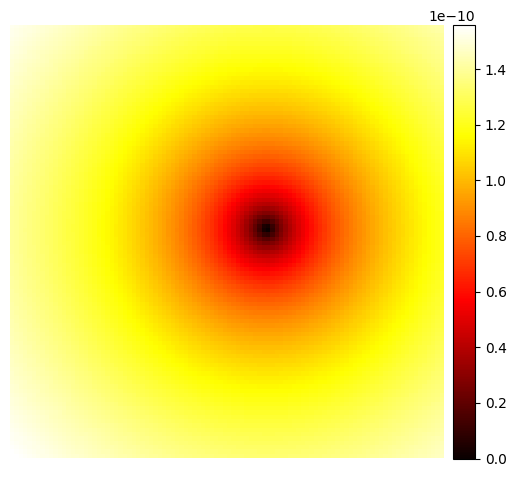

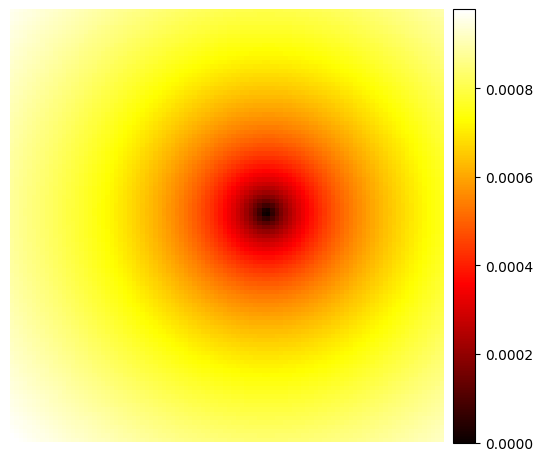

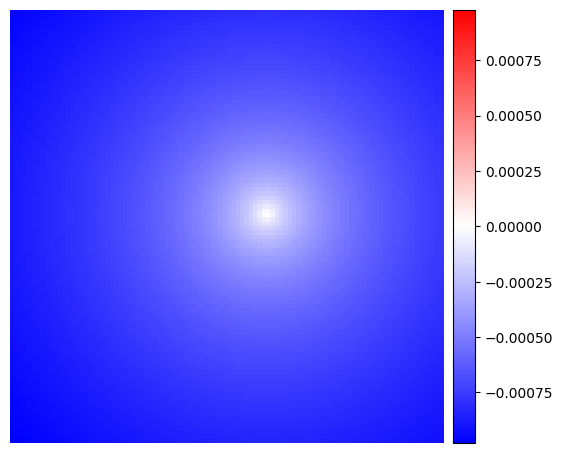

AssertionError: 

In [116]:
atol = 1e-5
rtol = 3e-2

# Models
cosmology = CausticFlatLambdaCDM("cosmo")
z_l = torch.tensor(0.1)
lens_tnfw = TNFW("tnfw", cosmology, z_l=z_l)
lens_model_list = ["TNFW"]
lens_ls = LensModel(lens_model_list=lens_model_list)

print(lens_tnfw)

# Parameters
z_s = torch.tensor(0.5)

x0 = 0.457
y0 = 0.141
m = 1e12
c = 8.0
r_trunc = 0.034
params_tnfw = lens_tnfw.pack(torch.tensor([x0, y0, m, c, r_trunc]))

# Lenstronomy
cosmo = FlatLambdaCDM_AP(H0=h0_default * 100, Om0=Om0_default, Ob0=Ob0_default)
lens_cosmo = LensCosmo(z_lens=z_l.item(), z_source=z_s.item(), cosmo=cosmo)
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=m, c=c)

# lenstronomy params ['Rs', 'alpha_Rs', r_trunc, 'center_x', 'center_y']
kwargs_ls = [
    {"Rs": Rs_angle, "alpha_Rs": alpha_Rs, "r_trunc": r_trunc, "center_x": x0, "center_y": y0}
]

# lens_test_helper(lens_tnfw, lens_ls, z_s, params_tnfw, kwargs_ls, atol, rtol)
Psi_test_helper(lens_tnfw, lens_ls, z_s, params_tnfw, kwargs_ls, atol, rtol)
# alpha_test_helper(lens_tnfw, lens_ls, z_s, params_tnfw, kwargs_ls, atol, rtol)
# kappa_test_helper(lens_tnfw, lens_ls, z_s, params_tnfw, kwargs_ls, atol, rtol)

In [50]:
z_l, x0, y0, m, c, r_trunc = lens_tnfw.unpack(params_tnfw)

In [51]:
# dir(lens_ls.lens_model.func_list)
# dir(lens_ls.lens_model.func_list[0])
rho0 = lens_ls.lens_model.func_list[0].alpha2rho0(alpha_Rs, Rs_angle)
r, tau = lens_tnfw.get_r_tau(thx, thy, z_l, params_tnfw)
rho_s = lens_tnfw.get_scale_density(z_l, c, params_tnfw)

In [112]:
d_l = lens_tnfw.cosmology.angular_diameter_distance(z_l, params_tnfw)
scale_radius = lens_tnfw.get_scale_radius(z_l, m, c, params_tnfw)
rho_cr = lens_tnfw.cosmology.critical_density(z_l, params_tnfw)
Sigma_cr = lens_tnfw.cosmology.critical_surface_density(z_l, z_s, params_tnfw)


In [114]:
scale_radius / d_l * rad_to_arcsec

tensor(13.3906)

In [111]:
Sigma_cr

tensor(5.4358e+15)

In [110]:
critical_density

tensor(1.4008e+11)

In [56]:
rho0

0.0012822203292759957

In [76]:
critical_density

tensor(1.4008e+11)

In [22]:
fac_ls = 2 * rho0 * Rs_angle ** 3

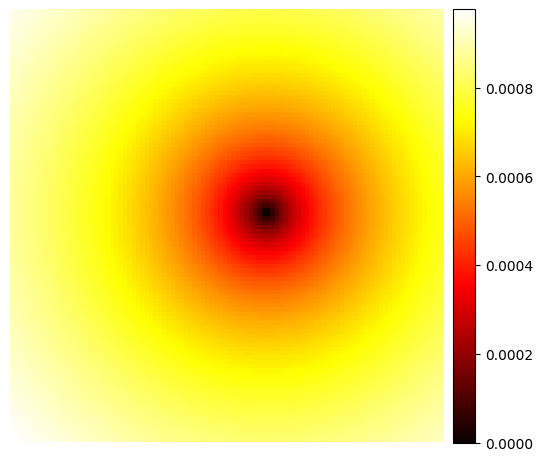

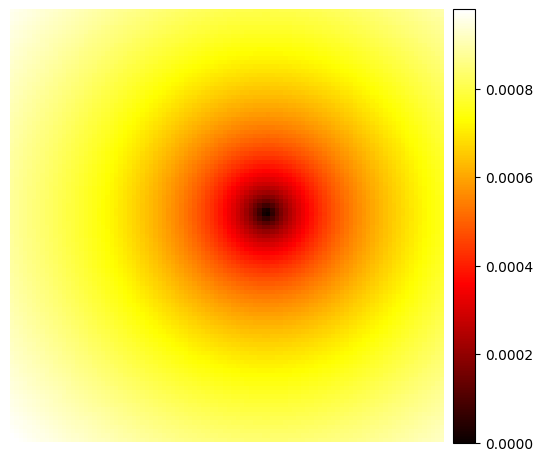

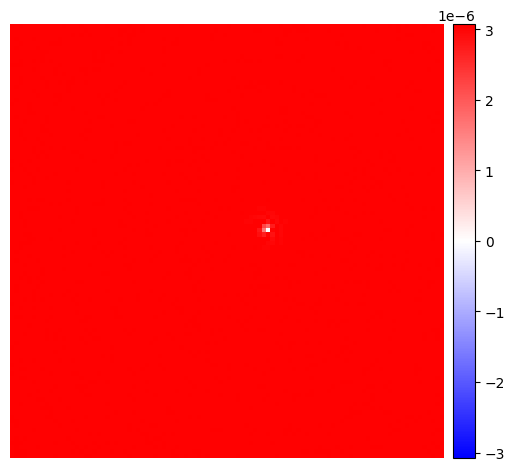

(<matplotlib.image.AxesImage at 0x7f1ff49df7f0>, None)

In [109]:
hx = lens_tnfw._H(r, tau)
hx_ls = lens_ls.lens_model.func_list[0]._h(r.numpy(), tau.numpy())

F = lens_tnfw._F(r)
L = lens_tnfw._L(r, tau)
F_ls = lens_ls.lens_model.func_list[0].F(r.numpy())
L_ls = lens_ls.lens_model.func_list[0]._L(r.numpy(), tau.numpy())

psi_ls = fac_ls * hx_ls
psi_ls -= psi_ls.min()

psi = fac_ls * hx
# psi = lens_tnfw.potential(thx, thy, z_s, params_tnfw)
psi -= psi.min()

display(psi_ls, cmap="hot", norm=None)
display(psi, cmap="hot", norm=None)
display(psi - psi_ls)

# display(F, cmap="hot", norm=None)
# display(F_ls, cmap="hot", norm=None)
# display(F - F_ls)
# display(L, cmap="hot", norm=None)
# display(L_ls, cmap="hot", norm=None)
# display(L - L_ls)

# display(hx, cmap="hot", norm=None)
# display(hx_ls, cmap="hot", norm=None)
# display(lens_tnfw._cos_function(r), cmap="hot", norm=None)
# display(lens_ls.lens_model.func_list[0]._cos_function(r.numpy()), cmap="hot", norm=None)
# display(lens_tnfw._cos_function(r) - lens_ls.lens_model.func_list[0]._cos_function(r.numpy()))

657861.318443271

In [35]:
potential_tnfw = lens_tnfw.potential(thx ,thy, z_s, params_tnfw)

tensor(7.6433e+11)
tensor([[0.2935, 0.2907, 0.2880,  ..., 0.2423, 0.2445, 0.2468],
        [0.2910, 0.2882, 0.2855,  ..., 0.2393, 0.2416, 0.2439],
        [0.2886, 0.2858, 0.2830,  ..., 0.2363, 0.2386, 0.2409],
        ...,
        [0.2754, 0.2724, 0.2694,  ..., 0.2200, 0.2224, 0.2249],
        [0.2776, 0.2747, 0.2718,  ..., 0.2228, 0.2252, 0.2277],
        [0.2799, 0.2770, 0.2741,  ..., 0.2257, 0.2281, 0.2305]])


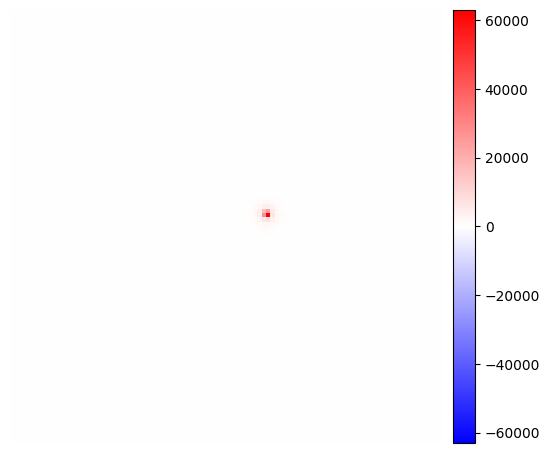

tensor(7.6433e+11)


In [50]:
z_l, x0, y0, m, c, r_trunc = lens_tnfw.unpack(params_tnfw)

ax_tnfw, ay_tnfw = lens_tnfw.reduced_deflection_angle(thx, thy, z_s, params_tnfw)
kappa_tnfw = lens_tnfw.convergence(thx ,thy, z_s, params_tnfw)


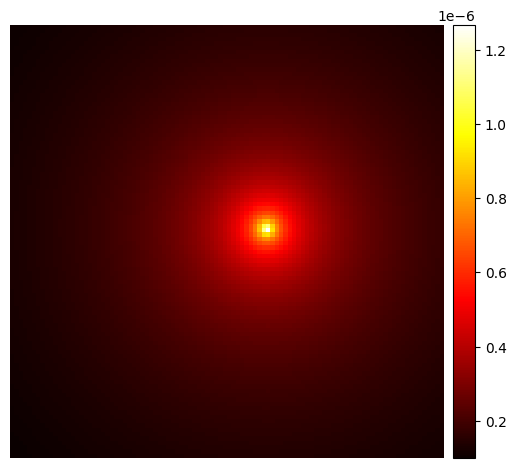

(<matplotlib.image.AxesImage at 0x7f80ae76cfa0>, None)

In [32]:
# display(ax_tnfw)
# display(kappa_tnfw, cmap="hot", norm=None)

display(potential_tnfw, cmap="hot", norm=None)

In [14]:
potential_tnfw

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])